In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import *
from matplotlib import cm

# Punto 2

In [2]:
k = 8.987*10**9
p = 1.602*10**-19
carga = k*p
x = np.linspace(-1.0, 1.0, 100)
y = np.linspace(-1.0, 1.0, 100)
X,Y = np.meshgrid(x,y)

In [3]:
def crear_cargas_en_circulo(carga, N=1000, R=0.2):
    angulos = np.linspace(0, 2*np.pi, N, endpoint=False)
    c = 1.0*carga
    X, Y, cargas = [], [], []
    #x = [(R*np.cos(angulo), R*np.sin(angulo), carga) for angulo in angulos]
    for angulo in angulos:
        X.append(R*np.cos(angulo))
        Y.append(R*np.sin(angulo))
        cargas.append(c)
    return X, Y, cargas

In [4]:
def plot_cargas(X_fuente, Y_fuente, N, R):
    plt.figure(figsize=(15,15))
    plt.plot(X_fuente, Y_fuente, '.', color='#83eb7a')
    plt.title('Arreglo circular de {} cargas con R={}'.format(N,R))
    plt.show()

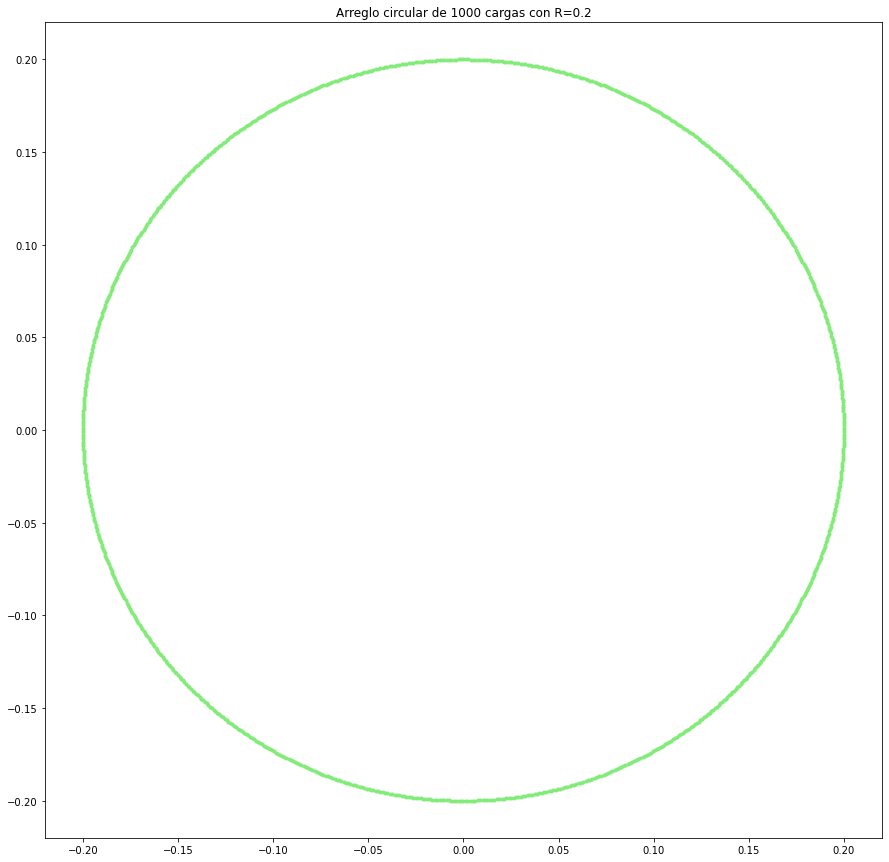

In [5]:
N, R = 1000, 0.2
X_fuente, Y_fuente, cargas = crear_cargas_en_circulo(carga, N, R)
plot_cargas(X_fuente, Y_fuente, N, R)

In [6]:
def campo_electrico(X, X_fuente, Y, Y_fuente, cargas, e=0.01):
    x_componente = (cargas*(X - X_fuente))/((X - X_fuente)**2 + (Y - Y_fuente)**2 + e)**1.5
    y_componente = (cargas*(Y - Y_fuente))/((X - X_fuente)**2 + (Y - Y_fuente)**2 + e)**1.5
    return x_componente, y_componente

In [7]:
def magnitud_campo_electrico(campo, X, X_fuente, Y, Y_fuente, cargas, carga):
    X_total, Y_total = 0,0 
    for i in range(len(X_fuente)):
        x_componente, y_componente = campo(X, X_fuente[i], Y, Y_fuente[i], cargas[i])
        X_total += x_componente
        Y_total += y_componente
    return np.sqrt(X_total**2 + Y_total**2)/carga

In [8]:
E = magnitud_campo_electrico(campo_electrico, X, X_fuente, Y, Y_fuente, cargas, carga)

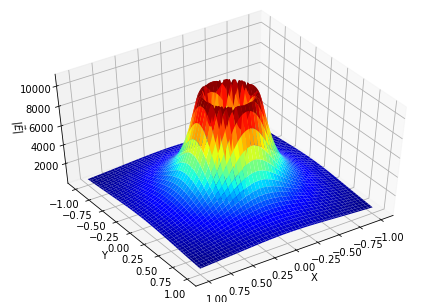

In [9]:
fig = plt.figure()
ax = Axes3D(fig, elev = 48, azim = 56)
ax.plot_surface(X,Y, E, cmap=cm.jet, linewidth=1.0)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel(r'$|\vec{E}|$')
plt.show()

In [10]:
def potencial(X_i, X_k, Y_i, Y_k, cargas, e=0.01):
    return cargas/((X_i - X_k)**2 + (Y_i - Y_k)**2 + e)**(1/2)

In [11]:
def potencial_total(V, X_i, X_k, Y_i, Y_k, cargas, k):
    V_total = 0
    for i in range(len(X_k)):
        if X_i != X_k and Y_i != Y_k:
            V_total += V(X, X_k[i], Y, Y_k[i], cargas[i])
    return k*V_total

In [14]:
X, Y, cargas = crear_cargas_en_circulo(carga, N, R)
V = potencial_total(potencial, X, X[0], Y, Y[0], cargas[i], k)

TypeError: can't multiply sequence by non-int of type 'float'